In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hvplot
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [9]:
df = pd.read_csv('./data/data.csv', index_col='dt', parse_dates=True)

In [10]:
df.describe()

,MW
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [11]:
df.head()

,MW
dt,
2011-01-01 00:00:00,3416.0
2011-01-01 00:15:00,4755.0
2011-01-01 00:30:00,4939.0
2011-01-01 00:45:00,4939.0
2011-01-01 01:00:00,4998.0


In [12]:
def compute_statistics(X):
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))

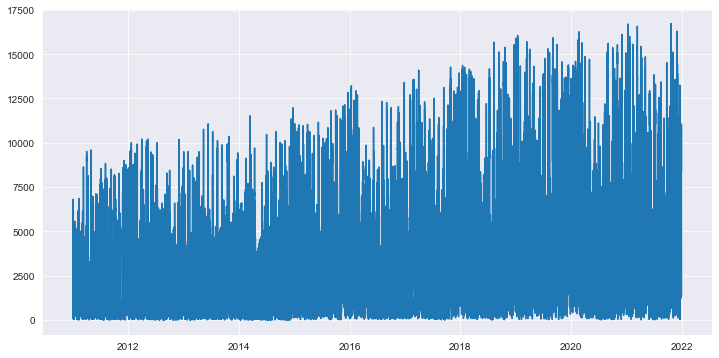

In [13]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['MW'])
plt.show()

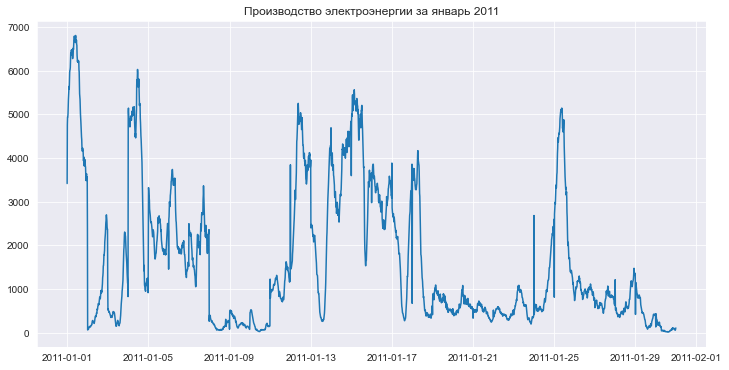

In [14]:
plt.figure(figsize=(12,6))
plt.plot(df.index[0: 4 * 24 * 30], df['MW'][0: 4 * 24 * 30])
plt.title('Производство электроэнергии за январь 2011')
plt.show()

In [15]:
compute_statistics(df['MW'])

mean1=2397.971131, mean2=3969.149830
variance1=5538196.485787, variance2=11783064.338773


По графику и по расчетам статистик видно, что среднее значение увеличивается, значит присутствует восходящий тренд. Дисперсия изменяется. Ряд нестационарный

In [16]:
print('Количество пропущенных значений: ', df['MW'].isnull().sum())

Количество пропущенных значений:  0


Т.к. предстоит делать долгосрочный прогноз - год, нет смысла прогнозировать по дням. Сделаем ресемплинг на месяц

In [17]:
df = df.resample("M").sum()

In [18]:
df.tail()

,MW
dt,
2021-08-31,11472360.83
2021-09-30,9261421.11
2021-10-31,13798147.07
2021-11-30,12171375.01
2021-12-31,12654287.86


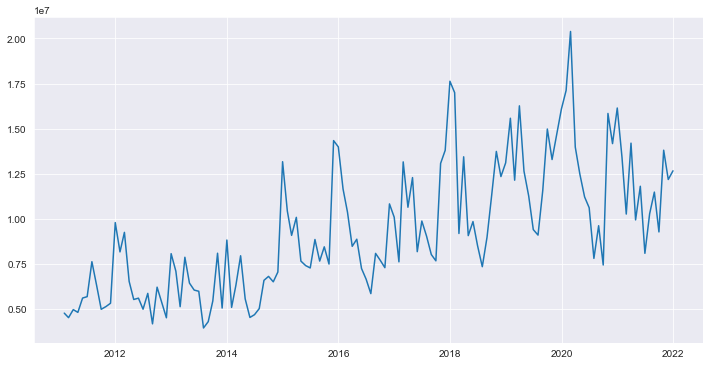

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['MW'])
plt.show()

Дисперсия изменяется. Присутствует тренд
Проверяем также стационарность при помощи теста Дики Фуллера и строим график  корреллограмм.


In [20]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 14), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.395004
p-value                          0.584669
#Lags Used                       9.000000
Number of Observations Used    122.000000
Critical Value (1%)             -3.485122
Critical Value (5%)             -2.885538
Critical Value (10%)            -2.579569
dtype: float64


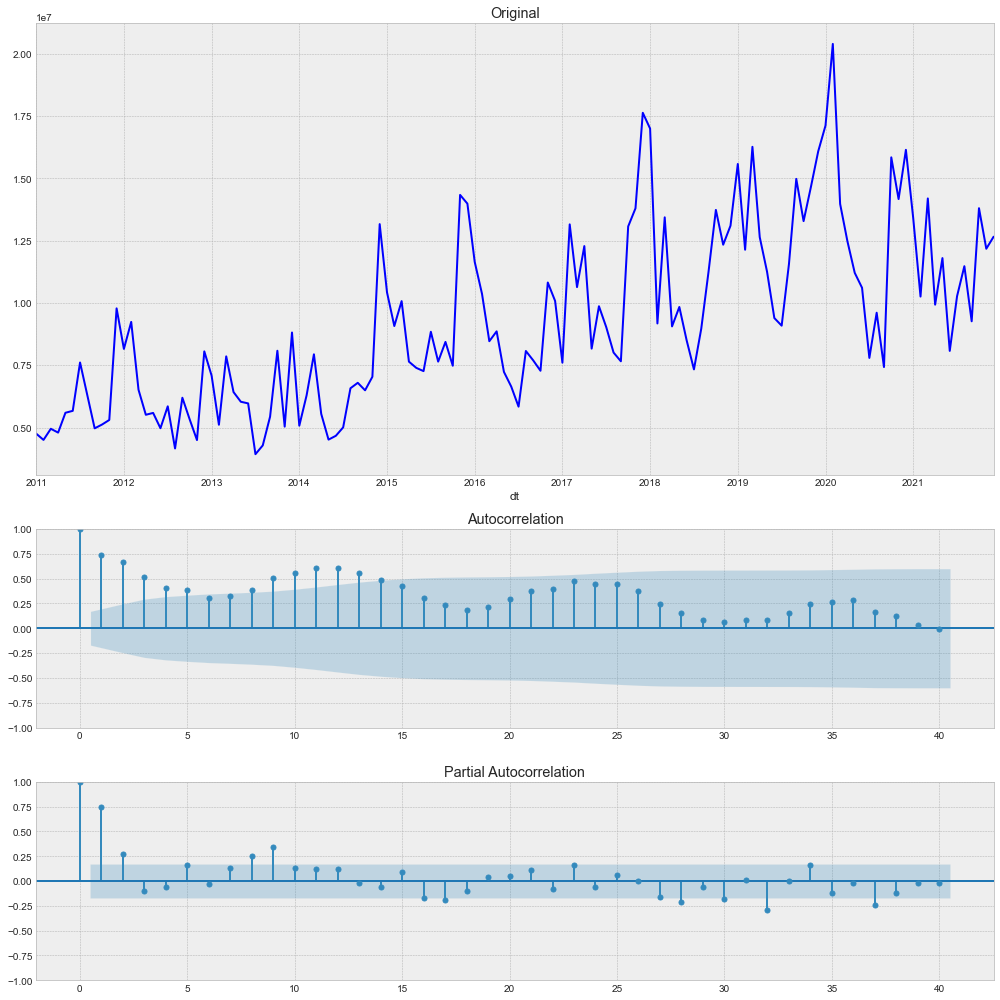

In [21]:
tsplot(df.MW, lags=40)

По результатам проведения теста Дикки Фуллера значение p-value 0.58 > 0.05 - следовательно, ряд нестационарный.
По  графику ACF видно, что в данных присутствует сильная положительная корреляция на 12 лаге - это сезонная составляющая.
Избавляемся от нестационарности

Results of Dickey-Fuller Test:
Test Statistic                -8.091822e+00
p-value                        1.371765e-12
#Lags Used                     8.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


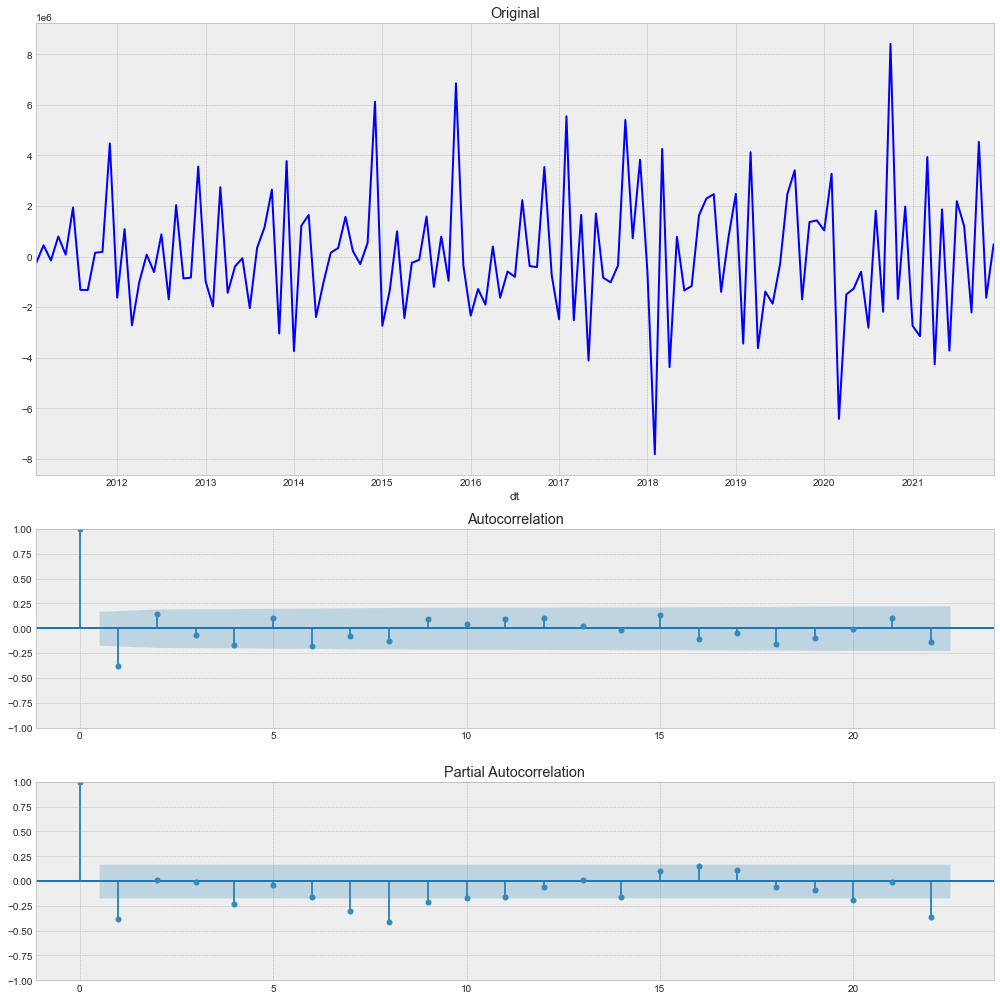

In [22]:
ts_diff = df.MW.diff(periods=1).dropna()
tsplot(ts_diff)

Получили интегрированный ряд первого порядка. Он стационарный - p-value < 0.05. Тренд отсутствует. 
По коррелограмме ACF можно увидеть, что q = 1, по PACF p = 1
Присутствует сезонность. Чтобы избавится от сезонности выполним сезонное дифференцирование s=12.

Results of Dickey-Fuller Test:
Test Statistic                  -4.153365
p-value                          0.000789
#Lags Used                      13.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


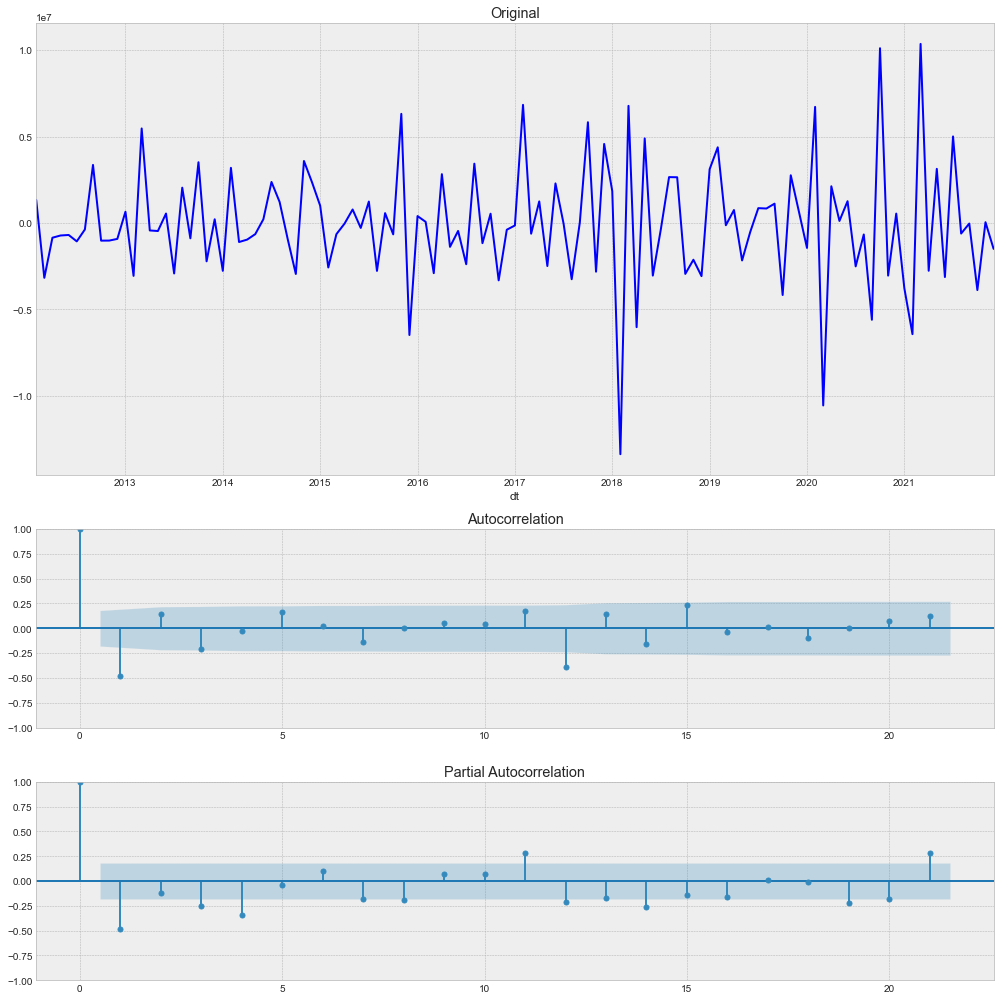

In [23]:
ts_diff1_season = ts_diff.diff(12).dropna()
tsplot(ts_diff1_season)

Получившийся ряд стационарен. Посмотрим на распределение данных и перейдем к построению модели.

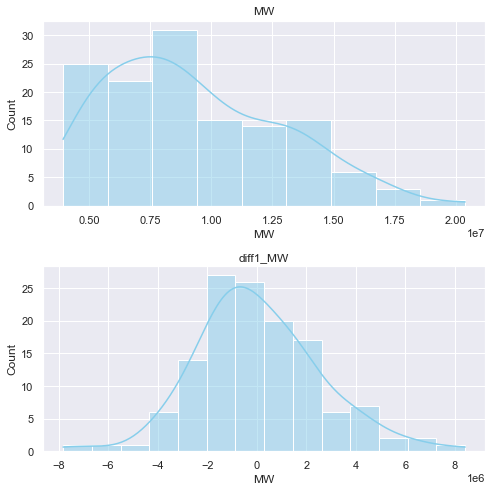

In [24]:
import seaborn as sns
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 1, figsize=(7, 7))

sns.histplot(data=df, x="MW", kde=True, color="skyblue", ax=axs[0]).set(title='MW')
sns.histplot(data=ts_diff, kde=True, color="skyblue", ax=axs[1]).set(title='diff1_MW')

plt.show()


Т.к. есть ярко выраженная сезонная составляющая будем использовать модель SARIMA.
Порядок интегрированности исходного ряда и сезонной составляющей d=1 и D=0. Остальные гиперпараметры найдем подбором путем анализа параметра AIC

In [25]:
from itertools import product
from tqdm import tqdm_notebook

ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 0
Qs = range(0, 2)
s = 12

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [26]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df.MW, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

def plotSARIMA(series, model, n_steps, s=12, d=1, plot_intervals=True, alpha=0.2):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']

    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    # forecasting on n_steps forward
    forecast = best_model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))

    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")

    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")


    plt.legend()
    plt.grid(True);

result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

In [27]:
result_table.head()

,parameters,aic
0,"(4, 4, 0, 0)",4191.477029
1,"(4, 2, 0, 0)",4196.307820
2,"(3, 3, 1, 1)",4199.867633
3,"(4, 3, 1, 1)",4201.411125
4,"(2, 4, 1, 1)",4202.073674


In [28]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df.MW, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                     MW   No. Observations:                  132
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -2086.739
Date:                Tue, 25 Oct 2022   AIC                           4191.477
Time:                        22:01:09   BIC                           4217.354
Sample:                    01-31-2011   HQIC                          4201.992
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5580      0.242      2.306      0.021       0.084       1.032
ar.L2          0.8037      0.187      4.297      0.000       0.437       1.170
ar.L3         -0.7489      0.210     -3.568      0.0

Results of Dickey-Fuller Test:
Test Statistic                -1.125719e+01
p-value                        1.655923e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.310000e+02
Critical Value (1%)           -3.481282e+00
Critical Value (5%)           -2.883868e+00
Critical Value (10%)          -2.578677e+00
dtype: float64


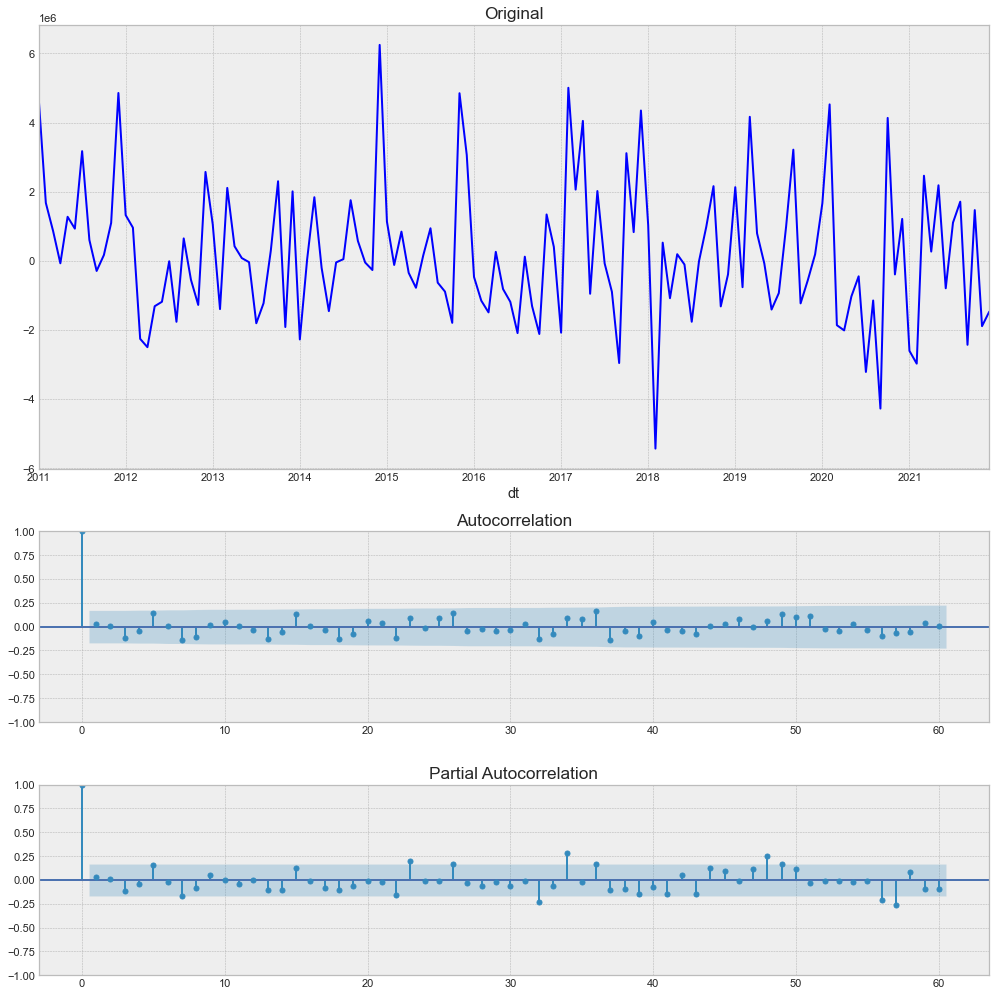

In [29]:
tsplot(best_model.resid, lags=60)

Остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

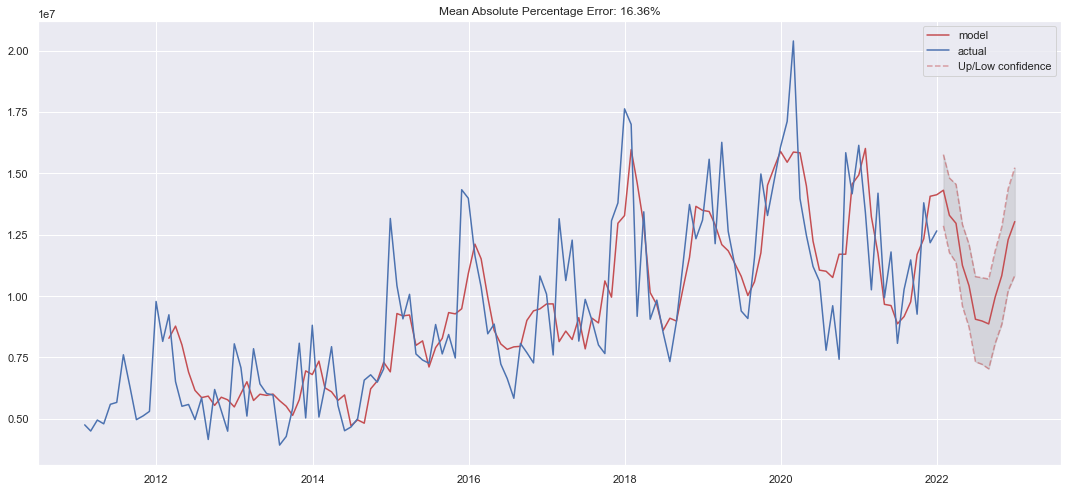

In [30]:
plotSARIMA(df, best_model, 12, alpha=0.5)

В результате получаем прогноз со средней абсолютной ошибкой в 16 процентов